# Calculating 1D and 2D Molecular Descriptors Using RDKit and Mordred

In [1]:
import sys
import os
import pandas
import numpy
import seaborn
from typing import List, Dict
from pandas import DataFrame
from numpy import ndarray
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem import Mol
from rdkit.DataStructs.cDataStructs import ExplicitBitVect
from rdkit.Chem import MACCSkeys
from rdkit.Avalon import pyAvalonTools
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina

os.environ['MOL_DESCRIPTORS_PYTHON_DIR_PATH'] =  os.path.join(os.getcwd(), '../src')
os.environ['MOL_DESCRIPTORS_DATA_DIR_PATH'] =  os.path.join(os.getcwd(), '../data')
sys.path.append(os.getenv('MOL_DESCRIPTORS_PYTHON_DIR_PATH'))

from utils import molecular_descriptors_utils
from constants.smiles_constants import SmilesConstants

## 1. Load SMILES Data Set

In [2]:
# SMILES data set extracted from https://zivgitlab.uni-muenster.de/m_kueh11/fp-dm-tool
# Data set gives SMILES strings and HOMO-LUMO energy gap (in meV)
mol_descriptors_data_dir: str = os.path.join(os.getcwd(), '../data')
dataset: DataFrame = pandas.read_csv(os.path.join(mol_descriptors_data_dir, 'orbital_energies_input_data.csv'))

## 2. Generate Canonical SMILES

### 2.1 Illustration of SMILES as Non-Unique Identifiers

SMILES strings are **not unique identifiers**. There are many equivalent options to generate a SMILES string for a given structure. For example, for the molecule 1-butene:

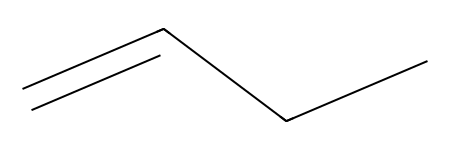

In [3]:
butene_smiles_a: str = 'C=CCC'
butene_mol_a: str = Chem.MolFromSmiles(butene_smiles_a)
butene_mol_a

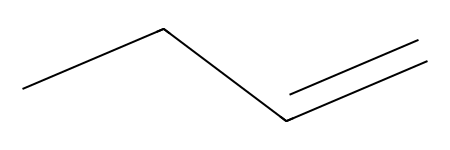

In [4]:
butene_smiles_b: str = 'CCC=C'
butene_mol_b: str = Chem.MolFromSmiles(butene_smiles_b)
butene_mol_b

In [5]:
butene_smiles_a == butene_smiles_b

False

As you can see, despite this being the same molecule, Python does not consider them to be equivalent. This is why we have to **canonicalise SMILES strings** to generate a **unique SMILES representation**.

Canonical SMILES are generated using the **CANGEN algorithm** which can be broken down into two parts:
1. **CANON Part** - Labels the atoms of the molecular structure canonically (i.e. in a unique way based on the structural topology)
2. **GENES Part** - Generates a unique SMILES from the canonical labelling and the core SMILES rules set

### 2.2 Canonicalize SMILES

In [6]:
# Canonicalize SMILES and insert into dataframe
dataset[SmilesConstants.SMILES] = molecular_descriptors_utils.generate_canonical_smiles(dataset.SMILES)

### 2.3 Idenitfy & Remove Duplicate Canonical SMILES

In [7]:
duplicate_canonical_smiles: List = dataset[dataset['SMILES'].duplicated()]['SMILES'].values
dataset[dataset['SMILES'].isin(duplicate_canonical_smiles)].sort_values(by=['SMILES'])

,SMILES,Energygap
218,C1=CCCCCCC1,214.097913
2125,C1=CCCCCCC1,214.097913
1901,C1CC[C@H]2CCCC[C@@H]2C1,251.144790
552,C1CC[C@H]2CCCC[C@@H]2C1,251.144790
554,C=CN1CCCC1=O,190.834900
1808,C=CN1CCCC1=O,190.835527
2203,C=Cc1ccccc1,168.467969
1354,C=Cc1ccccc1,168.475499
2341,C=Cc1ccccc1,168.490559
1265,C=Cc1ccncc1,174.833420


In [8]:
# Remove any duplicate canonical SMILES from data set. Make copy with `copy()` method so that it can be
# used with method `PandasTools.AddMoleculeColumnToFrame()` later
sanitised_dataset: DataFrame = dataset.drop_duplicates(subset=[SmilesConstants.SMILES]).copy()

### 2.4 Illustration of Canonical SMILES as Unique Identifiers

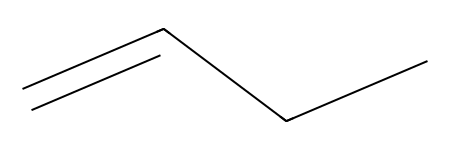

In [9]:
butene_canonical_smiles_a: str = molecular_descriptors_utils.generate_canonical_smiles(['C=CCC'])
butene_canonical_mol_a: Mol = Chem.MolFromSmiles(butene_canonical_smiles_a[0])
butene_canonical_mol_a

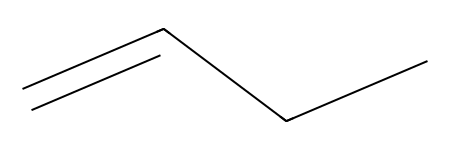

In [10]:
butene_canonical_smiles_b: str = molecular_descriptors_utils.generate_canonical_smiles(['CCC=C'])
butene_canonical_mol_b: Mol = Chem.MolFromSmiles(butene_canonical_smiles_b[0])
butene_canonical_mol_b

In [11]:
butene_canonical_smiles_a == butene_canonical_smiles_b

True

After the SMILES strings have been canonicalised, they generate the same Mol object and the new canonicalised SMILES strings are considered equivalent by Python

## 3. Insert Molecular 2D Structure into Dataset

In [12]:
PandasTools.AddMoleculeColumnToFrame(sanitised_dataset,'SMILES', 'Structure')

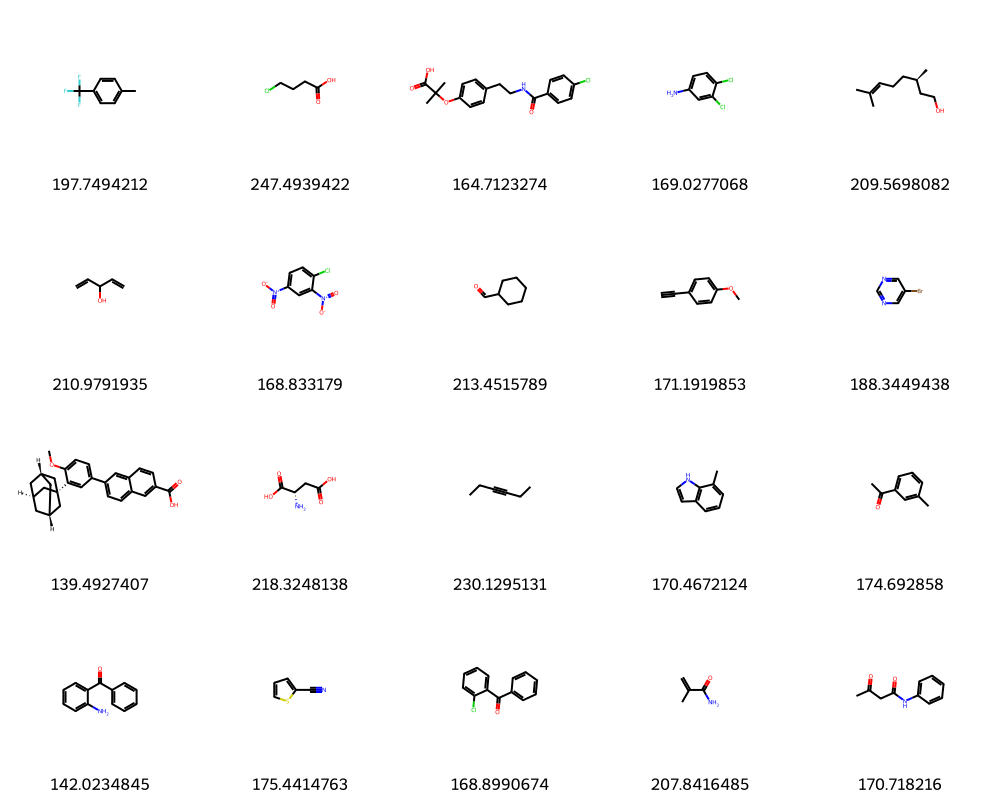

In [13]:
# Illustrate 2D structure in first 20 elements of data set in a grid image, with their HOMO-LUMO energy
# gap as the legend
Draw.MolsToGridImage([structure for structure in sanitised_dataset['Structure']][:20], maxMols=100,
                     legends=[str(energy_gap) for energy_gap in sanitised_dataset.Energygap],
                     subImgSize=(200,200), molsPerRow=5)

## 3. Molecular Descriptors in the RDKit Library

In this section, we will generate the following molecular descriptors via the RDKit library:
* Molecular ACCess System keys or MACCS-keys
* Avalon fingerprint
* Atom-pair fingerprint
* Topological-Torsions fingerprint.
* Morgan fingerprint (Circular Fingerprint)
* RDKit Fingerprint

<div align="center">
    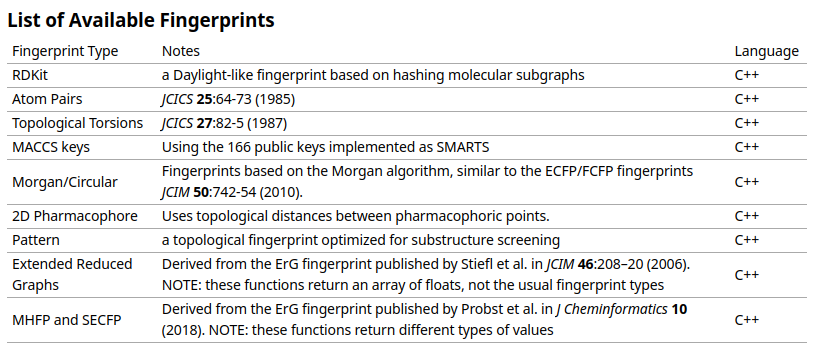
    <p>
        <b>Fig 1</b> Molecular descriptors available in the RDKit library
    </p>
</div>

### 3.1 Calculate MACCS-Keys Fingerprint (166 Public Keys) for All Canonical SMILES in Data Set

The MACCS-keys are a set of structural keys encoding for a set predefined substructures/fragments, with each bit indicating the absence or presence of a particular substructure/fragment.

The one available in the RDKit library can be seen in [MACCSkeys.py](https://github.com/rdkit/rdkit/blob/master/rdkit/Chem/MACCSkeys.py) in the RDKit GitHub repo

In [14]:
maccs_keys: List = []
for structure in sanitised_dataset.Structure:
    maccs_keys.append(MACCSkeys.GenMACCSKeys(structure))

# Print MACCS-Keys fingerprint of first molecule in dataset
print(numpy.array(maccs_keys[0]))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0]


There are two different ways to access all of the 'On' bits (1) in the RDKit generated MACCS-keys fingerprint. These 'On' bits indicate the presence of a given substructure/fragment

In [15]:
# Approach 1 - Using method `Mkeys.GetOnBits()`
print(f"\033[1mIndices of MACCS-keys fingerprint 'On' bits in molecule '{sanitised_dataset.SMILES[0]}'\033[0m:\n{tuple(maccs_keys[0].GetOnBits())}\n")
print(f"\033[1mNumber of MACCS-keys fingerprint 'On' bits in molecule '{sanitised_dataset.SMILES[0]}'\033[0m:\n{len(maccs_keys[0].GetOnBits())}")

Indices of MACCS-keys fingerprint 'On' bits in molecule 'Cc1ccc(C(F)(F)F)cc1':
(42, 106, 107, 112, 134, 160, 162, 163, 165)

Number of MACCS-keys fingerprint 'On' bits in molecule 'Cc1ccc(C(F)(F)F)cc1':
9


In [16]:
# Approach 2 - Using method `numpy.nonzero()`
print(f"\033[1mIndices of MACCS-keys fingerprint 'On' bits in molecule '{sanitised_dataset.SMILES[0]}'\033[0m:\n{numpy.nonzero(maccs_keys[0])}\n")
print(f"\033[1mNumber of MACCS-keys fingerprint 'On' bits in molecule '{sanitised_dataset.SMILES[0]}'\033[0m:\n{numpy.count_nonzero(maccs_keys[0])}")

Indices of MACCS-keys fingerprint 'On' bits in molecule 'Cc1ccc(C(F)(F)F)cc1':
(array([ 42, 106, 107, 112, 134, 160, 162, 163, 165]),)

Number of MACCS-keys fingerprint 'On' bits in molecule 'Cc1ccc(C(F)(F)F)cc1':
9


### 3.2 Calculate Avalon Fingerprint for All Canonical SMILES in Data Set

Similar to **Daylight fingerprints**, Avalon uses a **fingerprint generator** that enumerates certain paths and feature classes of the molecular graph **<sup>1</sup>**

In [17]:
avalon_fingerprints: List = []
for structure in sanitised_dataset.Structure:
    avalon_fingerprints.append(pyAvalonTools.GetAvalonFP(structure, nBits=512))

# Print Avalon fingerprint of first molecule in dataset
print(numpy.array(avalon_fingerprints[0]))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

Similarly to the MACCS-keys fingerprint, we can use the `GetOnBits()` method to identify the indices and number of 'On' bits in the Avalon fingerpint

In [18]:
print(f"\033[1mIndices of Avalon fingerprint 'On' bits in molecule '{sanitised_dataset.SMILES[0]}'\033[0m:\n{tuple(avalon_fingerprints[0].GetOnBits())}\n")
print(f"\033[1mNumber of Avalon fingerprint 'On' bits in molecule '{sanitised_dataset.SMILES[0]}'\033[0m:\n{len(avalon_fingerprints[0].GetOnBits())}")

Indices of Avalon fingerprint 'On' bits in molecule 'Cc1ccc(C(F)(F)F)cc1':
(18, 58, 67, 81, 92, 124, 138, 150, 153, 157, 196, 198, 206, 207, 221, 222, 234, 250, 266, 274, 282, 293, 305, 324, 328, 333, 341, 343, 351, 367, 383, 389, 390, 401, 455, 464, 472, 478, 508)

Number of Avalon fingerprint 'On' bits in molecule 'Cc1ccc(C(F)(F)F)cc1':
39


### 3.3 Calculate Atom-Pairs Fingerprint for All Canonical SMILES in Data Set

**Atom-pairs** is a simple type of substructure that is defined in terms of the atomic environments of, and shortest path separation between **all pairs of atoms** in the topological representation of a chemical structure. **<sup>2</sup>**

The atom-pairs fingerprint is an algorithm for computing atom pairs from this aforementioned representation.

In [19]:
atom_pairs_fingerprints: List = []
for structure in sanitised_dataset.Structure:
    atom_pairs_fingerprints.append(
        rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(structure, nBits=512)
    )

# Print atom-pairs fingerprint of first molecule in dataset
print(numpy.array(atom_pairs_fingerprints[0]))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 0 0 1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 0 0 0 

Again, we can use the `GetOnBits()` method to identify the indices and number of 'On' bits in the atom-pairs fingerpint

In [20]:
print(f"\033[1mIndices of atom-pairs fingerprint 'On' bits in molecule '{sanitised_dataset.SMILES[0]}'\033[0m:\n{tuple(atom_pairs_fingerprints[0].GetOnBits())}\n")
print(f"\033[1mNumber of atom-pairs fingerprint 'On' bits in molecule '{sanitised_dataset.SMILES[0]}'\033[0m:\n{len(atom_pairs_fingerprints[0].GetOnBits())}")

Indices of atom-pairs fingerprint 'On' bits in molecule 'Cc1ccc(C(F)(F)F)cc1':
(36, 88, 89, 92, 128, 129, 140, 160, 161, 162, 220, 221, 224, 225, 226, 232, 233, 248, 249, 276, 277, 292, 293, 336, 340, 341, 344, 388, 389, 412, 420, 421, 422, 472, 473, 484, 485, 486, 500, 501, 508, 509)

Number of atom-pairs fingerprint 'On' bits in molecule 'Cc1ccc(C(F)(F)F)cc1':
42


### 3.4 Calculate Topological-Torsions (TT) Fingerprint for All Canonical SMILES in Data Set

The topological-torsion (TT) fingerprint is a molecular descriptor that consists of **four consecutively bonded non-hydrogen atoms** along with the **number of non-hydrogen branches**. The descriptor is basically the topological analogue of the basic conformational element, the **torsion angle**.

The atom-pair and TT fingerprints **capture and magnify distinct aspects of molecular topology**. **<sup>3</sup>**

In [21]:
tt_fingerprints: List = []
for structure in sanitised_dataset.Structure:
    tt_fingerprints.append(
        rdMolDescriptors.GetHashedTopologicalTorsionFingerprintAsBitVect(structure, nBits=512)
    )
# Print topological-torsion fingerprint of first molecule in dataset
print(numpy.array(tt_fingerprints[0]))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

Again, we can use the `GetOnBits()` method to identify the indices and number of 'On' bits in the TT fingerpint

In [22]:
print(f"\033[1mIndices of TT fingerprint 'On' bits in molecule '{sanitised_dataset.SMILES[0]}'\033[0m:\n{tuple(tt_fingerprints[0].GetOnBits())}\n")
print(f"\033[1mNumber of TT fingerprint 'On' bits in molecule '{sanitised_dataset.SMILES[0]}'\033[0m:\n{len(tt_fingerprints[0].GetOnBits())}")

Indices of TT fingerprint 'On' bits in molecule 'Cc1ccc(C(F)(F)F)cc1':
(176, 177, 178, 248, 249, 356, 357, 380, 381, 382, 464, 465)

Number of TT fingerprint 'On' bits in molecule 'Cc1ccc(C(F)(F)F)cc1':
12


### 3.5 Calculate Morgan Fingerprints for All Canonical SMILES in Data Set

The **Morgan Algorithm** is an iterative process that maps/assigns numeric identifiers to each atom in a molecule within a certain radius of organic bonds. For this reason Morgan fingerprints (and others based on the Morgan algorithm such as **Extended-Connectivity Fingerprints (ECFPs)**) are also known as **circular fingerprints**.

In [23]:
morgan_fingerprints: ndarray = molecular_descriptors_utils.calculate_morgan_fingerprints(
    sanitised_dataset[SmilesConstants.SMILES]
)

morgan_fingerprints_dataframe: DataFrame = DataFrame(
    morgan_fingerprints,
    columns=['Col_{}'.format(i) for i in range(morgan_fingerprints.shape[1])]
)

### 3.6 Calculate RDKit Fingerprint for All Canonical SMILES in Data Set

The RDKit library also provides an eponymous fingerprint that starts by **labelling all atoms with their atomic number/aromaticity** and **all edges with their bond type** and then **enumerates the set of all subgraphs within a certain size limit**.

In [24]:
rdkit_fingerprint_info: Dict = {}
rdkit_fingerprints: List = []
for structure in sanitised_dataset.Structure:
    rdkit_fingerprint = AllChem.RDKFingerprint(
        structure,
        maxPath=5, 
        fpSize=512, 
        bitInfo=rdkit_fingerprint_info
    )
    rdkit_fingerprints.append(rdkit_fingerprint)
    
print(numpy.array(rdkit_fingerprints[0]))

[0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0
 1 0 0 0 1 0 0 0 0 0 1 0 

In [25]:
print(f"\033[1mIndices of RDKit fingerprint 'On' bits in molecule '{sanitised_dataset.SMILES[0]}'\033[0m:\n{tuple(rdkit_fingerprints[0].GetOnBits())}\n")
print(f"\033[1mNumber of RDKit fingerprint 'On' bits in molecule '{sanitised_dataset.SMILES[0]}'\033[0m:\n{len(rdkit_fingerprints[0].GetOnBits())}")

Indices of RDKit fingerprint 'On' bits in molecule 'Cc1ccc(C(F)(F)F)cc1':
(2, 9, 16, 17, 19, 27, 28, 36, 40, 41, 62, 63, 93, 103, 124, 127, 137, 152, 157, 161, 170, 192, 194, 196, 205, 232, 248, 252, 271, 278, 280, 294, 309, 314, 324, 330, 342, 343, 353, 373, 383, 389, 405, 418, 432, 437, 441, 451, 460, 465, 470, 473, 481, 485, 491, 501)

Number of RDKit fingerprint 'On' bits in molecule 'Cc1ccc(C(F)(F)F)cc1':
56


### 3.7 Calculate Mordred Descriptors for All Canonical SMILES in Data Set

Mordred is a Python package that can calculate more than 1800 0D, 1D, 2D and 3D molecular descriptors

## 4. Calculate RDKit Descriptors for All Canonical SMILES in Data Set

Using the `Descriptors.descList` method we can obtain all RDKit descriptora via a list of tuples where each tuple contains a descriptor name and its corresponding function.

We can then create a list of descriptor names by extracting the first element (name) from each tuple, and initialise a `rdkit.ML.Descriptors.MoleculeDescriptors.MolecularDescriptorCalculator()` class descriptor calculator with this list

## 5. Calculate Tanimoto Coefficient for First Two Molecules in Data Set

The **Tanimoto similarity algorithm** provides a measure of similarity between the molecular fingerprints of two molecules. Usually, these two molecular fingerprints are represented as two sets of **fingerprint 'bits'**, denoted as *A* and *B*. 

The **Tanimoto coefficient**, *T(A,B)*, is calculated as the ratio of the intersection of *A* and *B* to the union of *A* and *B* (**Fig 2**). This coefficient ranges from **0**, indicating **no common bits** between the fingerprints, to **1**, representing **identical fingerprints**.
<br>
<div align="center">
    <img src="https://latex.codecogs.com/svg.latex?T%20%3D%20%5Cfrac%7B%7CA%20%5Ccap%20B%7C%7D%7B%7CA%7C%20%2B%20%7CB%7C%20-%20%7CA%20%5Ccap%20B%7C%7D", alt='tanimoto-coefficient-equation'/>
</div>
<br>

<div align="center">
    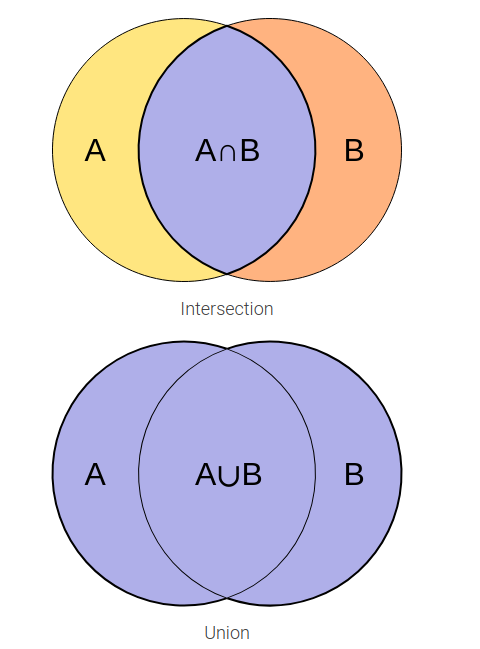
    <p>
        <b>Fig 2</b> Tanimoto Coefficient equation and schematic
    </p>
</div>

Below we will calculate the Tanimoto coefficient for the Morgan fingerprints of the first two molecules in the data set

In [26]:
# Calcualte Morgan fingerprints
molecule_2: Mol = AllChem.MolFromSmiles(sanitised_dataset['SMILES'][2])
molecule_10: Mol = AllChem.MolFromSmiles(sanitised_dataset['SMILES'][10])

molecule_2_morgan_fingerprint: ExplicitBitVect = AllChem.GetMorganFingerprintAsBitVect(
    molecule_2,
    2,
    nBits=2048,
    bitInfo={}
)
molecule_10_morgan_fingerprint: ExplicitBitVect = AllChem.GetMorganFingerprintAsBitVect(
    molecule_10,
    2,
    nBits=2048,
    bitInfo={}
)

# Calculate Tanimoto coefficient betwee Morgan fingerprints using RDKit
DataStructs.FingerprintSimilarity(
    molecule_2_morgan_fingerprint,
    molecule_10_morgan_fingerprint,
    metric=DataStructs.TanimotoSimilarity
)

print(f"\033[1mTanimoto Similarity between molecules '{sanitised_dataset.SMILES[2]}' and '{sanitised_dataset.SMILES[10]}'\033[0m:\n"
      f"{DataStructs.FingerprintSimilarity(molecule_2_morgan_fingerprint, molecule_10_morgan_fingerprint, metric=DataStructs.TanimotoSimilarity)}")

Tanimoto Similarity between molecules 'CC(C)(Oc1ccc(CCNC(=O)c2ccc(Cl)cc2)cc1)C(=O)O' and 'COc1ccc(-c2ccc3cc(C(=O)O)ccc3c2)cc1[C@]12C[C@H]3C[C@H](C[C@H](C3)C1)C2':
0.16666666666666666


## 6. Applications of Molecular Fingerprints

The two applications of molecular fingerprints we will look at in this section are:
1. **Searching for Compounds** (e.g. using a **Tanimoto similarity search**)
2. **Compound Clustering**

### 6.1 Searching for Compounds Similar to a Query Compound

In this section we will query the sanitised dataset for all compounds similar to the compound **acetylsalicylic acid** (aspirin).

This will be achieved by performing a Tanimoto similarity search of the Morgan fingerprint for acetylsalicylic acid against the Morgan fingerprints of all compounds in the sanitised dataset

In [27]:
# Generate aspirin Mol object from SMILES
aspirin_mol: Mol = AllChem.MolFromSmiles('O=C(C)Oc1ccccc1C(=O)O')

# Calculate aspririn Morgan fingerprint
aspirin_morgan_fingerprint: ExplicitBitVect = AllChem.GetMorganFingerprintAsBitVect(
    aspirin_mol, 
    2, 
    nBits=4096
)

dataset_morgan_fingerprints: List = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=4096) for mol in sanitised_dataset['Structure']]

# Calculate Tanimoto coefficient of aspirin query compound against each compound in the data set
# and insert into list
aspirin_tanimoto_coefficients: List = [
    DataStructs.FingerprintSimilarity(
        aspirin_morgan_fingerprint, 
        dataset_morgan_fingerprint, 
        metric=DataStructs.TanimotoSimilarity
    ) for dataset_morgan_fingerprint in dataset_morgan_fingerprints
]

# Insert Tanimoto coefficient values into new 'Aspirin Tanimoto Coefficient' column
sanitised_dataset['Aspirin Tanimoto Coefficient'] = aspirin_tanimoto_coefficients

# Sort aspirin Tanimoto coefficient values into data frame
sorted_sanitised_dataset: DataFrame = sanitised_dataset.sort_values(['Aspirin Tanimoto Coefficient'], ascending=False)

# Use a threshold value to filter compounds below a certain similarity
sorted_sanitised_dataset[sorted_sanitised_dataset['Aspirin Tanimoto Coefficient'] >= 0.5]

,SMILES,Energygap,Structure,Aspirin Tanimoto Coefficient
1339,CC(=O)Oc1ccccc1C(=O)O,194.030175,<rdkit.Chem.rdchem.Mol object at 0x7eaf277c4430>,1.000000
2518,COc1ccccc1C(=O)O,177.605755,<rdkit.Chem.rdchem.Mol object at 0x7eaf277e42e0>,0.655172
2504,CCOc1ccccc1C(=O)O,177.259370,<rdkit.Chem.rdchem.Mol object at 0x7eaf277e3c30>,0.593750
1226,O=C(O)c1ccccc1Oc1ccccc1,170.710058,<rdkit.Chem.rdchem.Mol object at 0x7eaf277c12a0>,0.562500
2387,O=C(O)c1ccccc1C(=O)O,174.361533,<rdkit.Chem.rdchem.Mol object at 0x7eaf277e09e0>,0.538462
2726,COc1cccc(C(=O)O)c1OC,167.069879,<rdkit.Chem.rdchem.Mol object at 0x7eaf277e9d90>,0.500000
2728,Cc1ccccc1C(=O)O,187.182170,<rdkit.Chem.rdchem.Mol object at 0x7eaf277e9e70>,0.500000


From our Tanimoto similarity query, we can see that compound 1339 has a Tanimoto coefficient of 1.0 against aspirin, indicating that compound 1339 is in fact aspirin. We can see this if we output the structures and their Tanimoto coefficients:

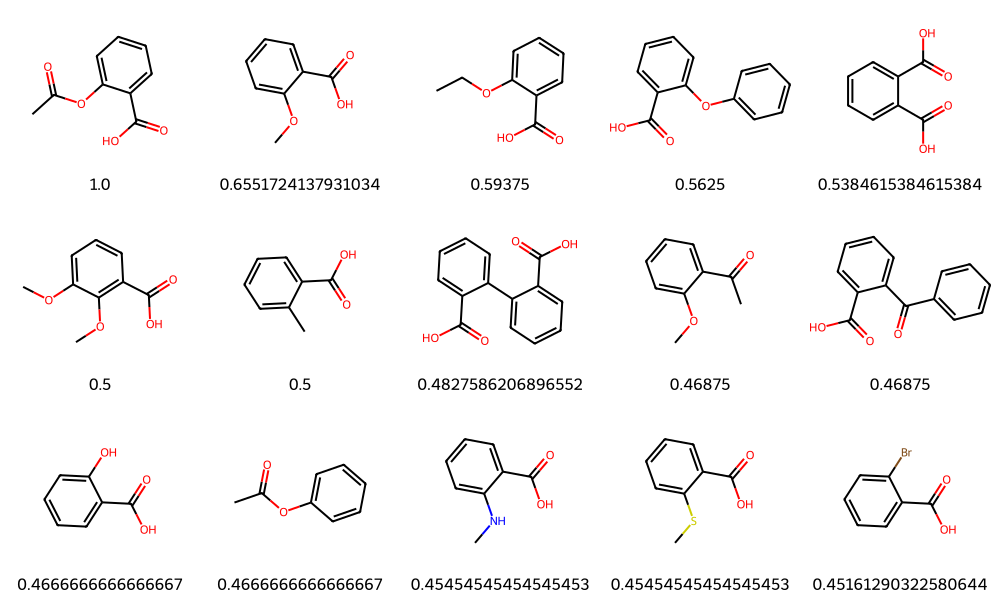

In [28]:
# Display structures and Tanimoto coefficient values 
Draw.MolsToGridImage([x for x in sorted_sanitised_dataset["Structure"]][:15], maxMols=100, 
                     legends=[str(tanimoto_coefficient) for tanimoto_coefficient in sorted_sanitised_dataset['Aspirin Tanimoto Coefficient']], 
                     subImgSize=(200,200), molsPerRow=5)

### 6.2 Compound Clustering

**Cluster Analysis or Clustering** is the task of grouping of a set of objects (usually **unlabelled data**) in such a way that objects in the same group (a **cluster**) are **more similar to each other** than those in **other groups/clusters**.

As clustering/cluster analysis is used on **unlabelled data** (i.e. data where the elements have **no distinct identifiers or classifications**), it is defined under the branch of **unsupervised learning** in machine learning. Unsupervised learning aims at **gaining insights from unlabelled data points**.

The algorithm we will use to perform our clustering/cluster analysis is called **Taylor-Butina Clustering**. **<sup>6</sup> <sup>7</sup>** 

Taylor-Butina clustering is a **unsupervised, non-hierarchical clustering method** that **guarantees every cluster contains molecules which are within a distance cutoff from to the central molecule**.
    * Non-hierarchical cluserting here refers to clustering methods that **do not produce a nested series of clusters**. Instead they create a **single paritioning of the data into a set of distinct clusters**.
    * This contrasts with **hierarchical clustering**, which creates a **tree-like structure of clusters** that can be **divided or combined at various level**

First we need to create a **tanimoto coefficient 

## References

**[1]** Gedeck, P., Rohde, B. and Bartels, C. (2006) ‘QSAR − how good is it in practice? comparison of descriptor sets on an unbiased cross section of corporate data sets’, *Journal of Chemical Information and Modeling*, 46(5), pp. 1924–1936. <br><br>
**[2]** Carhart, R.E., Smith, D.H. and Venkataraghavan, R. (1985) ‘Atom pairs as molecular features in structure-activity studies: Definition and applications’, *Journal of Chemical Information and Computer Sciences*, 25(2), pp. 64–73. <br><br>
**[3]** Nilakantan, R. et al. (1987) ‘Topological torsion: A new molecular descriptor for SAR applications. comparison with other descriptors’, *Journal of Chemical Information and Computer Sciences*, 27(2), pp. 82–85. <br><br>
**[4]** Tanimoto, TT., (1957), "An Elementary Mathematical theory of Classification and Prediction", *Internal IBM Technical Report*, pp. 8. <br><br>
**[5]** Rácz, A., Bajusz, D. and Héberger, K. (2018) ‘Life beyond the Tanimoto coefficient: Similarity measures for interaction fingerprints’, *Journal of Cheminformatics*, 10(1). <br><br>
**[6]** Taylor, R. (1995) ‘Simulation analysis of experimental design strategies for screening random compounds as potential new drugs and agrochemicals’, *Journal of Chemical Information and Computer Sciences*, 35(1), pp. 59–67.
**[7]** Butina, D. (1999) ‘Unsupervised data base clustering based on Daylight’s fingerprint and Tanimoto similarity: A fast and automated way to cluster small and large data sets’, *Journal of Chemical Information and Computer Sciences*, 39(4), pp. 747–750.